# Implementing Long Short Term Memory with Keras

## Loading and Visualizing Data

In [485]:
import numpy
import pandas as pd 
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [486]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andreazzini/international-airline-passengers")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\edvard.smoliakov\.cache\kagglehub\datasets\andreazzini\international-airline-passengers\versions\1


In [487]:
data = pd.read_csv(path+'/international-airline-passengers.csv',skipfooter=5, engine='python') # The last 5 data was contaminated
data.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


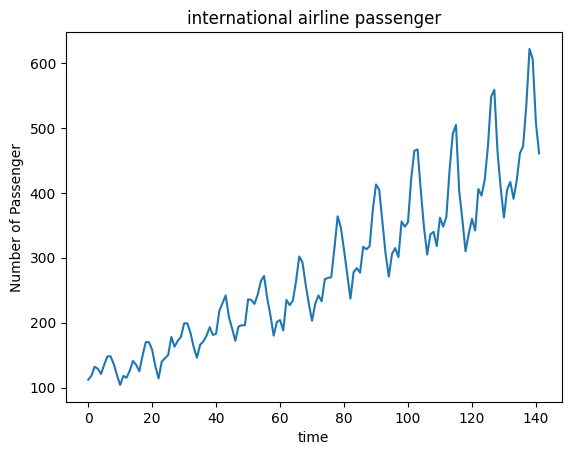

In [488]:
dataset = data.iloc[:,1].values
plt.plot(dataset)
plt.xlabel("time")
plt.ylabel("Number of Passenger")
plt.title("international airline passenger")
plt.show()

## Preprocessing Data
Reshape

Change type

Scaling

Train test split

Create dataset

In [489]:
# LSTM expects 2D or 3D input
dataset = dataset.reshape(-1,1) # outputs a column with many rows
dataset = dataset.astype("float32")
dataset.shape

(142, 1)

In [490]:
# scaling 
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [491]:
train_size = int(len(dataset) * 0.50)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:]
test = dataset[train_size:len(dataset),:]
print("train size: {}, test size: {} ".format(len(train), len(test)))

train size: 71, test size: 71 


In [492]:
time_stemp = 10 # Use the previous 10 time steps to predict the next value

dataX = []
dataY = []
for i in range(len(train)-time_stemp-1):
    a = train[i:(i+time_stemp), 0]
    dataX.append(a)
    dataY.append(train[i + time_stemp, 0])
trainX = numpy.array(dataX)
trainY = numpy.array(dataY)  

In [493]:
dataX = []
dataY = []
for i in range(len(test)-time_stemp-1):
    a = test[i:(i+time_stemp), 0]
    dataX.append(a)
    dataY.append(test[i + time_stemp, 0])
testX = numpy.array(dataX)
testY = numpy.array(dataY) 

In [494]:
trainX.shape

(60, 10)

In [495]:
# LTSM expects shape: (samples, timesteps, features)
trainX = numpy.reshape(trainX, (trainX.shape[0], time_stemp, 1))
testX = numpy.reshape(testX, (testX.shape[0], time_stemp, 1))
"Here: samples = number of training examples. timesteps = 10. features = 1. So each sample is treated as one time step with 10 features"

'Here: samples = number of training examples. timesteps = 10. features = 1. So each sample is treated as one time step with 10 features'

## Create LSTM Model

In [496]:
## Model's layer breakdown:
# Input layer: shape (1, 10)
# LSTM layer:
#   10 memory cells (neurons)
#   Learns temporal dependencies
# Dense layer:
#   Outputs a single value (next passenger count)
from keras.layers import Dropout
model = Sequential()
model.add(Input(shape=(time_stemp, 1)))
model.add(LSTM(10))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0118
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039   
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029   
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028   
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029   
Epoch 13/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028   
Epoch 14/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026   
Epoch 15/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029  

## Predictions and Visualising LSTM Model

In [497]:
# Predictions are scaled in 0–1 range:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions - back to actual passenger numbers
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error to measure average prediction error (lower is better)
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Train Score: 23.25 RMSE
Test Score: 63.49 RMSE


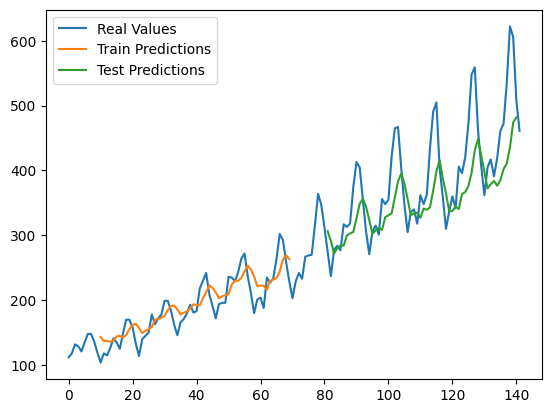

In [498]:
# shifting train
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[time_stemp:len(trainPredict)+time_stemp, :] = trainPredict

# shifting test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(time_stemp*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label = "Real Values")
plt.plot(trainPredictPlot, label = "Train Predictions")
plt.plot(testPredictPlot, label = "Test Predictions")
plt.legend()
plt.show()

## Assignment

 
1) Examin the original notebook. Identify why timesteps=1 is unusual and explain how to choose time_stemp properly! 
2) Try different window sizes (e.g., 5, 15) and explain impact.
3) Why normalization matters for neural networks?
4) Experiment with number of neurons (5, 10, 20) and activation functions. Explain impact!
5) Train with different batch sizes and epochs. Explain impact!
6) If there is a different evaluation metric, try that!

Advanced:

7) Predict multiple months ahead (e.g., next 3 months) instead of one.
8) Improve performance with Dropout or multiple LSTM layers.
9) Predict next 12 months and plot the forecast.

In [499]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
mae = mean_absolute_error(testY[0], testPredict[:,0])
mae

46.93302380310681

In [500]:
mape = numpy.mean(numpy.abs((testY[0] - testPredict[:,0]) / testY[0])) * 100
mape

np.float64(11.058883679155882)

In [501]:
r2 = r2_score(testY[0], testPredict[:,0])
r2

0.4368035229873295

## Assignment:
1) The timesteps is 10, it is unusual, because the dataset has months and there are 12 months in a year, it would be logical to use timesteps=12. Choosing timesteps depends on dataset and goals, to see weekly patterns in daily data it would be 7. In other datasets best choosing is done with testing couple candidates and choosing the one who gives lowest RMSE. 
2) timesteps=5 gives similar train and test RMSE as timesteps=10, timesteps=15 gives much worse test RMSE, it cant predict the spike level. timesteps=12 gives best training RMSE and worst test RMSE, showing overfitting. This is because there are too little training samples left.
3) Normalization matters, because they learn through gradient descent while updating weights, if data is raw the weights can get skewed and make model unstable. The activation functions output flatlines and gradients vanish, model stops learning.
4) 5 neurons: the model underfits, 5 neurons is too little to capture seasonal patterns. 10 neurons: works decently. 20 neurons: the model overfits, training RMSE is great but test no.
Sigmoid activation is very flat, cannot capture individual up down patterns, suppresses them. Relu does not work with this. Linear is LSTM default.
5) Batch sizes: Epochs: 10 is too little, model cannot learn spikes(cannot converge), 100 epochs is overfitting. Batch sizes: 16: misses patterns, 100: model underfits heavily, because the dataset is shown as one batch and only one gradient update per epoch. Best were default 50 epochs and 1 batch size. Dataset is small and has a lot of noise, each sample turns model in other direction.
6) Used MAE - less sensitive to spikes, MAPE - how wrong % on average, r2 - how much varianec model explains

### Advanced:
7) [[532.143], [497.81732], [473.75354]]
8) Added LSTM layer and Dropout both hurt performance, dropping neurons removes training ability. Having multiple layers overfits.
9) Started too high and finished too low. The model predicted off of previous prediction and did not predict correctly. Model was trained to predict one step ahead, not 12. 

In [504]:
# take the last known window from test set
last_window = testX[-1]
predictions = []

for _ in range(3):
    next_pred = model.predict(last_window.reshape(1, 10, 1))
    predictions.append(next_pred[0, 0])
    # drop oldest value, append new prediction
    last_window = numpy.append(last_window[1:], next_pred).reshape(10, 1)

# inverse transform to get actual passenger numbers
predictions = scaler.inverse_transform(numpy.array(predictions).reshape(-1, 1))
print("Next 3 months predicted passengers: ", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Next 3 months predicted passengers:  [[481.87762]
 [444.90833]
 [422.10132]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


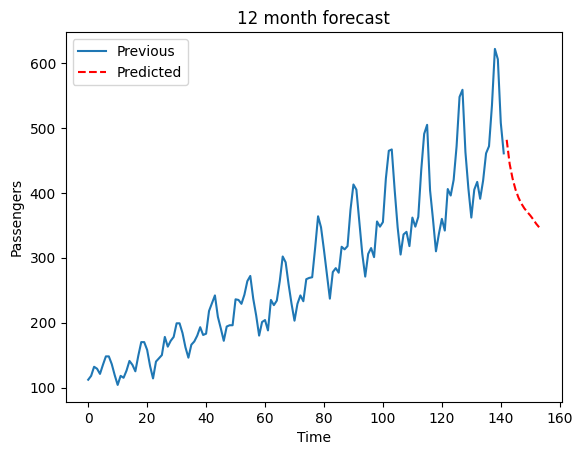

In [506]:
last_window = testX[-1]
predictions = []

for _ in range(12):
    next_pred = model.predict(last_window.reshape(1, 10, 1))
    predictions.append(next_pred[0, 0])
    last_window = numpy.append(last_window[1:], next_pred).reshape(10, 1)

predictions = scaler.inverse_transform(numpy.array(predictions).reshape(-1, 1))

plt.plot(scaler.inverse_transform(dataset), label="Previous")
plt.plot(range(len(dataset), len(dataset) + 12), predictions, label="Predicted", linestyle='--', color='red')
plt.legend()
plt.title("12 month forecast")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.show()

#### License
This Notebook has been released under the Apache 2.0 open source license.

https://www.kaggle.com/code/moonglow22/rnn-and-lstm-tutorial-for-beginners/notebook